train:  2019
[[  9.304202  ]
 [ 11.288209  ]
 [ -3.9126005 ]
 [ 12.943931  ]
 [  6.448833  ]
 [ -0.55894226]
 [  2.5000062 ]
 [  2.4010344 ]
 [  4.091336  ]
 [ 11.2161    ]
 [  2.7808843 ]
 [ -5.58118   ]
 [ -0.9477325 ]
 [  7.2459707 ]
 [ -5.811213  ]
 [ -3.9730222 ]
 [ -1.95364   ]
 [  0.30849683]
 [-13.624258  ]
 [-11.001102  ]
 [-11.21699   ]
 [-10.495945  ]
 [ 10.576302  ]
 [ -6.649958  ]
 [  3.2911153 ]
 [ -1.3843296 ]
 [ -1.0087068 ]
 [ 11.861649  ]
 [  6.4371347 ]
 [ 10.602743  ]
 [-11.730178  ]
 [ -6.4718947 ]
 [ -7.2670856 ]
 [-11.730117  ]
 [  9.932471  ]
 [ -7.2552047 ]
 [ -5.810832  ]
 [ -9.623418  ]
 [ -6.4352646 ]
 [  4.878012  ]
 [  9.088107  ]
 [-11.388371  ]
 [  0.19565377]
 [-11.09748   ]
 [ -3.9730222 ]
 [-12.040566  ]
 [ -3.5471704 ]
 [ -8.447988  ]
 [ -6.3155065 ]
 [-10.673863  ]
 [-10.35323   ]
 [ -0.09784506]
 [ 14.152621  ]
 [  6.5551786 ]
 [  3.361122  ]
 [  6.6875205 ]
 [ -0.67110074]
 [ -5.216601  ]
 [ 14.547016  ]
 [  5.903043  ]
 [  4.6475863 ]
 [-11.81264

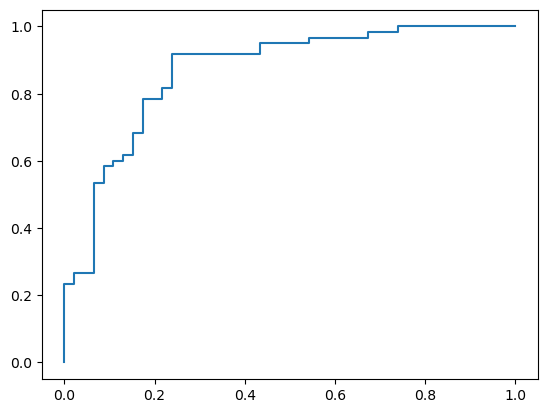

In [14]:
from __future__ import print_function, division

import time
import os
import copy
import random
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


from sklearn.metrics import roc_auc_score, roc_curve
from torch.nn.functional import softmax


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, imagepaths, transform):
        self.transform = transform
        self.imagepaths = imagepaths
    
    def __len__(self):
        return len(self.imagepaths)
    
    def __getitem__(self, idx):
        img = Image.open(self.imagepaths[idx])
        img = self.transform(img)
        label = self.imagepaths[idx].split('/')[-2]
        if label == '1':
            label = 1
        else:
            label = 0
        return img, label, self.imagepaths[idx]

cudnn.benchmark = True
plt.ion()   # interactive mode

if __name__ == '__main__':

    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([1024, 1024]),
        # transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
        transforms.RandomRotation(degrees=15, expand=False, fill=None),
        # flip
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.37955950568704044, 0.23169069477156096, 0.10694904701382506], [0.2844342100854014, 0.17562707639208028, 0.0917047986797258])
    ]),
    'test': transforms.Compose([
        transforms.Resize([1024, 1024]),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.37955950568704044, 0.23169069477156096, 0.10694904701382506], [0.2844342100854014, 0.17562707639208028, 0.0917047986797258])
    ]),
    }

    all_imagepaths = {'train': glob.glob('/home/philip/Documents/Philip_4T/Glaucoma_fundus/x-resnet/FundusGlaucomaEidon/dataset/train/*/*.jpg'),
                        'test': glob.glob('/home/philip/Documents/Philip_4T/Glaucoma_fundus/x-resnet/FundusGlaucomaEidon/dataset/test/*/*.jpg')}
    random.shuffle(all_imagepaths['train'])
    random.shuffle(all_imagepaths['test'])

    print('train: ', len(all_imagepaths['train']))

    data_dir = './dataset/'
    image_datasets = {x: CustomDataset(all_imagepaths[x], data_transforms[x]) for x in ['train','test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                                shuffle=True, num_workers=2) for x in ['train','test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
    class_names = ['0', '1']

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_ft = models.resnet34(pretrained=True)
    num_ftrs = model_ft.fc.in_features

    # dropout layer
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    # model_ft.fc = nn.Linear(num_ftrs, 2)
    # model_ft = model_ft.to(device)

    # load weights "wang_weights.pth"
    # model_ft.load_state_dict(torch.load('wang_weights.pt'))

    # dropout layer
    model_ft.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1),
    )

    model_ft = model_ft.to(device)

    model_ft= nn.DataParallel(model_ft)

    # load weights
    model_ft.load_state_dict(torch.load('/home/philip/Documents/Philip_4T/Glaucoma_fundus/x-resnet/FundusGlaucomaEidon/weights/2020-04-20-14-11-00/model_162_8.60377358490566_0.8677536231884058.pth'))
    
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.9)
    
    max_auc = 0
    # train, calcuate auc sensitivity and specificity in each epoch

    model_ft.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_gts = []
    all_imgnames = []
    for inputs, labels, imagenames in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_ft.zero_grad()
        with torch.no_grad():
            outputs = model_ft(inputs)
            # outputs = softmax(outputs, dim=1)
            all_preds.append(outputs.cpu().numpy())
            all_gts.append(labels.cpu().numpy())
            all_imgnames.append(imagenames)

    # print the false positive cases, and print the probability of being positive
    all_preds = np.concatenate(all_preds, axis=0)
    all_gts = np.concatenate(all_gts, axis=0)
    all_imgnames = np.concatenate(all_imgnames, axis=0)
    print(all_preds)
    
    # draw ROC curve
    auc = roc_auc_score(all_gts, all_preds)
    print('auc: ', auc)
    fpr, tpr, thresholds = roc_curve(all_gts, all_preds)
    plt.plot(fpr, tpr)
    plt.show()




    


